In [308]:
import os
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from mapboxgl.viz import LinestringViz
from mapboxgl.utils import create_color_stops, create_numeric_stops
from geojson import Feature, FeatureCollection, LineString

#categoried by road_types. from 10mil rows of data, outlier upperbounds -- mean+2std:
upperbound_delay_rt1_2std = 364.2580985017166 
upperbound_delay_rt2_2std = 416.00629003480043
upperbound_delay_rt3_2std = 1337.7260891639444
upperbound_delay_rt4_2std = 393.1583664937325
upperbound_delay_rt6_2std = 494.9713645058797
upperbound_delay_rt7_2std = 366.12815975980857
upperbound_delay_rt17_2std = -1.0
upperbound_delay_rt20_2std = -1.0

In [2]:
# Mapbox token
token = os.getenv('MAPBOX_ACCESS_TOKEN')

# Postgres Database login info
USER = os.getenv('WAZE_USER')
PASS = os.getenv('WAZE_PASS')
HOST = 'datalake.cyuk6whwgqww.us-west-2.rds.amazonaws.com'
PORT = '5432'
DB = 'db_datalake'

uri = 'postgresql://{}:{}@{}:{}/{}'.format(USER, PASS, HOST, PORT, DB)
engine = create_engine(uri)

In [3]:
df_datafiles = pd.read_sql_query("select * from waze.data_files;", con=engine)

In [4]:
df = pd.read_csv('waze_jams_10mil.csv')

In [665]:
df_datafiles.head()

,id,start_time_millis,end_time_millis,start_time,end_time,date_created,date_updated,file_name,json_hash
0,1,1513033380000,1513033440000,2017-12-11 23:03:00,2017-12-11 23:04:00,2018-06-12,2018-06-12,wazedata_2017_12_11_23_06_03_062.json,367f73e1e1f190bc817499e550575824
1,2,1513033500000,1513033560000,2017-12-11 23:05:00,2017-12-11 23:06:00,2018-06-12,2018-06-12,wazedata_2017_12_11_23_08_02_202.json,7063d4be9abff1f0958d07811f0a7b0b
2,3,1513033620000,1513033680000,2017-12-11 23:07:00,2017-12-11 23:08:00,2018-06-12,2018-06-12,wazedata_2017_12_11_23_10_01_621.json,5e5d4e897f7b09d856501fbd6fb850d7
3,4,1513033740000,1513033800000,2017-12-11 23:09:00,2017-12-11 23:10:00,2018-06-12,2018-06-12,wazedata_2017_12_11_23_12_01_862.json,fef7efe233322d955327b2355e8a5e28
4,5,1513033860000,1513033920000,2017-12-11 23:11:00,2017-12-11 23:12:00,2018-06-12,2018-06-12,wazedata_2017_12_11_23_14_01_742.json,1247d10314b085dcd3a9c0e527e608f8


In [666]:
df.head()

,id,uuid,pub_millis,pub_utc_date,start_node,end_node,road_type,street,city,country,...,speed_kmh,length,turn_type,level,blocking_alert_id,line,type,turn_line,datafile_id,pid
0,1866670844,1866670844,1512561891461,2017-12-06 12:04:51.461,NaN,S Hope St,7,Hope St,"Los Angeles, CA",US,...,NaN,250,NONE,5,4fcf81c4-0e54-323b-9e31-4e9289b92788,"[{'x': -118.253027, 'y': 34.054704}, {'x': -11...",NONE,NaN,501,194017
1,1866670844,1866670844,1512561891461,2017-12-06 12:04:51.461,NaN,S Hope St,7,Hope St,"Los Angeles, CA",US,...,NaN,250,NONE,5,4fcf81c4-0e54-323b-9e31-4e9289b92788,"[{'x': -118.253027, 'y': 34.054704}, {'x': -11...",NONE,NaN,1000,531318
2,1866670844,1866670844,1512561891461,2017-12-06 12:04:51.461,NaN,S Hope St,7,Hope St,"Los Angeles, CA",US,...,NaN,250,NONE,5,4fcf81c4-0e54-323b-9e31-4e9289b92788,"[{'x': -118.253027, 'y': 34.054704}, {'x': -11...",NONE,NaN,154,144247
3,1866670844,1866670844,1512561891461,2017-12-06 12:04:51.461,NaN,S Hope St,7,Hope St,"Los Angeles, CA",US,...,NaN,250,NONE,5,4fcf81c4-0e54-323b-9e31-4e9289b92788,"[{'x': -118.253027, 'y': 34.054704}, {'x': -11...",NONE,NaN,309,165476
4,1866670844,1866670844,1512561891461,2017-12-06 12:04:51.461,NaN,S Hope St,7,Hope St,"Los Angeles, CA",US,...,NaN,250,NONE,5,4fcf81c4-0e54-323b-9e31-4e9289b92788,"[{'x': -118.253027, 'y': 34.054704}, {'x': -11...",NONE,NaN,51,44394


In [668]:
df_datafiles=df_datafiles[['id', 'start_time', 'end_time']]

#### Check LA city ONLY

In [6]:
df = df[df.city == 'Los Angeles, CA']

checking some info & drop unnecessary columns

In [669]:
df_jam_w_time = pd.merge(df[['id', 'datafile_id', 'street', 'road_type', 'delay', 'length', 'line']], df_datafiles, left_on='datafile_id', right_on='id')

In [670]:
df_jam_w_time.drop(columns=['id_y'], inplace=True)

In [671]:
df_jam_w_time.rename({'id_x':'jam_id'}, axis='columns', inplace=True)

In [672]:
import matplotlib.pyplot as plt

#### Verify the time zone

In [673]:
datetime(2017,12,12,0,0,0,tzinfo=timezone('US/Pacific'))

datetime.datetime(2017, 12, 12, 0, 0, tzinfo=<DstTzInfo 'US/Pacific' LMT-1 day, 16:07:00 STD>)

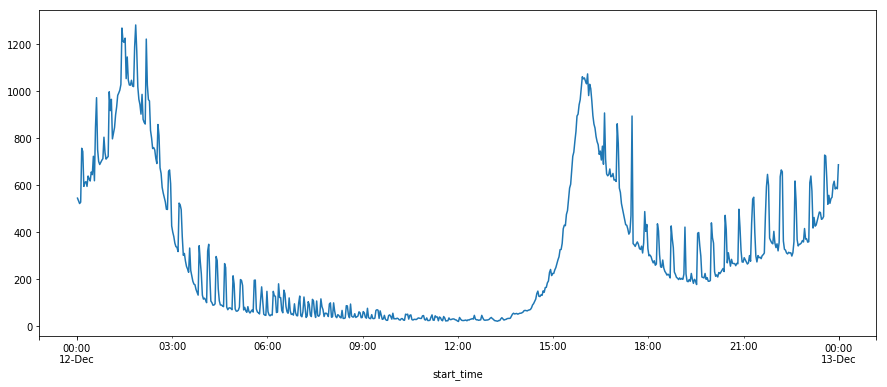

In [674]:
df_jam_w_time.groupby(['start_time']).size().loc[datetime(2017,12,12,0,0,0):datetime(2017,12,13,0,0,0)].plot(figsize=(15, 6))
plt.show()

### You can see the rush hours are around 2am and 4pm. The rush hour at 2am doesn't make any sense. But by converting them to local PST(subtract hours): 6pm and 8am, this makes perfect sense.

In [675]:
from datetime import datetime
from pytz import timezone
import pytz

In [676]:
df_jam_w_time['start_time'] = pd.to_datetime(df_jam_w_time['start_time'])
df_jam_w_time['end_time'] = pd.to_datetime(df_jam_w_time['end_time'])

Add time zone info

In [677]:
df_jam_w_time['start_time'] = df_jam_w_time['start_time'].apply(timezone('UTC').localize)

In [678]:
df_jam_w_time['end_time'] = df_jam_w_time['end_time'].apply(timezone('UTC').localize)

In [679]:
df_jam_w_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6543827 entries, 0 to 6543826
Data columns (total 9 columns):
jam_id         int64
datafile_id    int64
street         object
road_type      int64
delay          int64
length         int64
line           object
start_time     datetime64[ns, UTC]
end_time       datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(5), object(2)
memory usage: 499.3+ MB


In [680]:
df_jam_w_time.rename({'start_time':'start_time_utc', 'end_time':'end_time_utc'}, axis='columns', inplace=True)

Adding PST timezone

In [681]:
df_jam_w_time['start_time_pst'] = df_jam_w_time['start_time_utc'].apply(lambda x: x.astimezone(timezone('US/Pacific')))

In [682]:
df_jam_w_time['end_time_pst'] = df_jam_w_time['end_time_utc'].apply(lambda x: x.astimezone(timezone('US/Pacific')))

In [683]:
df_jam_w_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6543827 entries, 0 to 6543826
Data columns (total 11 columns):
jam_id            int64
datafile_id       int64
street            object
road_type         int64
delay             int64
length            int64
line              object
start_time_utc    datetime64[ns, UTC]
end_time_utc      datetime64[ns, UTC]
start_time_pst    datetime64[ns, US/Pacific]
end_time_pst      datetime64[ns, US/Pacific]
dtypes: datetime64[ns, US/Pacific](2), datetime64[ns, UTC](2), int64(5), object(2)
memory usage: 599.1+ MB


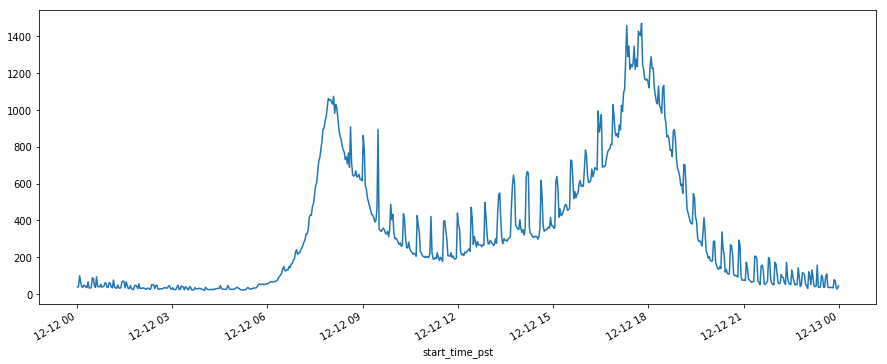

In [684]:
df_jam_w_time.groupby(['start_time_pst']).size().loc[datetime(2017,12,12,0,0,0):datetime(2017,12,13,0,0,0)].plot(figsize=(15, 6))
plt.show()

## Delay Outliers in a time window

In [685]:
# df_group_frequency = df_jam_w_datafiles.groupby([''])

In [686]:
from datetime import datetime, timedelta

Check a time window on a Friday afternoon

In [687]:
df_jam_time_index = df_jam_w_time.set_index('start_time_pst', drop=False)

In [688]:
df_jam_time_index.sort_index(inplace=True)

In [689]:
time_window_start = datetime(2017, 12, 15, 17,0,0, tzinfo=timezone('US/Pacific'))
time_window_end = datetime(2017, 12, 15, 18,0,0, tzinfo=timezone('US/Pacific'))

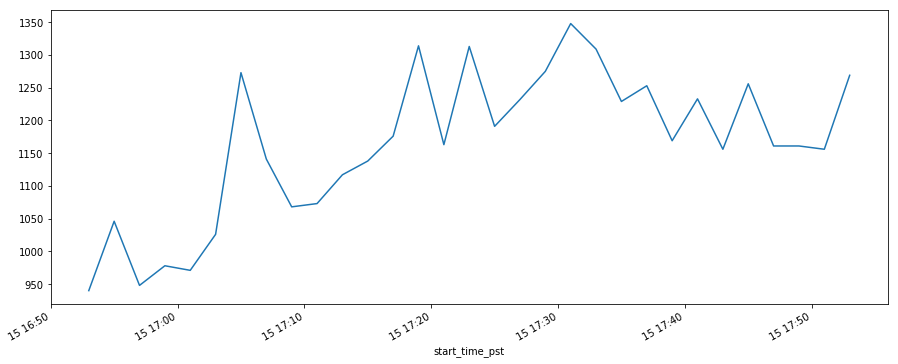

In [690]:
df_jam_w_time.groupby(['start_time_pst']).size().loc[time_window_start:time_window_end].plot(figsize=(15, 6))
plt.show()

In [691]:
df_time_window = df_jam_time_index.loc[time_window_start:time_window_end]
len(df_time_window)

36083

## Trying find outliers in categories of road types

In [697]:
sorted(df.road_type.unique())

[1, 2, 3, 4, 6, 7, 17, 20]

In [698]:
"""
Provided by WAZE data description
Value Type
1 Streets
2 Primary Street
3 Freeways
4 Ramps
5 Trails
6 Primary
7 Secondary
8,14 4X4 Trails
15 Ferry crossing
9 Walkway
10 Pedestrian
11 Exit
16 Stairway
17 Private road
18 Railroads
19 Runway/Taxiway
20 Parking lot road
21 Service road
"""

'\nValue Type\n1 Streets\n2 Primary Street\n3 Freeways\n4 Ramps\n5 Trails\n6 Primary\n7 Secondary\n8,14 4X4 Trails\n15 Ferry crossing\n9 Walkway\n10 Pedestrian\n11 Exit\n16 Stairway\n17 Private road\n18 Railroads\n19 Runway/Taxiway\n20 Parking lot road\n21 Service road\n'

In [699]:
df_jam_w_time.head()

,jam_id,datafile_id,street,road_type,delay,length,line,start_time_utc,end_time_utc,start_time_pst,end_time_pst
0,1866670844,501,Hope St,7,-1,250,"[{'x': -118.253027, 'y': 34.054704}, {'x': -11...",2017-12-12 15:43:00+00:00,2017-12-12 15:44:00+00:00,2017-12-12 07:43:00-08:00,2017-12-12 07:44:00-08:00
1,1873311008,501,Hope St SOUTH,7,-1,153,"[{'x': -118.253027, 'y': 34.054704}, {'x': -11...",2017-12-12 15:43:00+00:00,2017-12-12 15:44:00+00:00,2017-12-12 07:43:00-08:00,2017-12-12 07:44:00-08:00
2,1873311278,501,Aqua Vista St,2,-1,101,"[{'x': -118.3757, 'y': 34.14497}, {'x': -118.3...",2017-12-12 15:43:00+00:00,2017-12-12 15:44:00+00:00,2017-12-12 07:43:00-08:00,2017-12-12 07:44:00-08:00
3,1879251557,501,Aqua Vista St,2,-1,101,"[{'x': -118.37788, 'y': 34.144971}, {'x': -118...",2017-12-12 15:43:00+00:00,2017-12-12 15:44:00+00:00,2017-12-12 07:43:00-08:00,2017-12-12 07:44:00-08:00
4,1867711563,501,Aqua Vista St,2,-1,101,"[{'x': -118.37679, 'y': 34.144971}, {'x': -118...",2017-12-12 15:43:00+00:00,2017-12-12 15:44:00+00:00,2017-12-12 07:43:00-08:00,2017-12-12 07:44:00-08:00


In [700]:
df_roadtype_1 = df_jam_w_time[df_jam_w_time.road_type == 1]

In [701]:
df_roadtype_2 = df_jam_w_time[df_jam_w_time.road_type == 2]

In [702]:
df_roadtype_3 = df_jam_w_time[df_jam_w_time.road_type == 3]

In [703]:
df_roadtype_4 = df_jam_w_time[df_jam_w_time.road_type == 4]

In [704]:
df_roadtype_6 = df_jam_w_time[df_jam_w_time.road_type == 6]

In [705]:
df_roadtype_7 = df_jam_w_time[df_jam_w_time.road_type == 7]

In [706]:
df_roadtype_17 = df_jam_w_time[df_jam_w_time.road_type == 17]

In [707]:
df_roadtype_20 = df_jam_w_time[df_jam_w_time.road_type == 20]

In [708]:
upperbound_delay_rt1_2std = df_roadtype_1.delay.mean() + 2 * df_roadtype_1.delay.std()

In [709]:
upperbound_delay_rt2_2std = df_roadtype_2.delay.mean() + 2 * df_roadtype_2.delay.std()

In [710]:
upperbound_delay_rt3_2std = df_roadtype_3.delay.mean() + 2 * df_roadtype_3.delay.std()

In [711]:
upperbound_delay_rt4_2std = df_roadtype_4.delay.mean() + 2 * df_roadtype_4.delay.std()

In [712]:
upperbound_delay_rt6_2std = df_roadtype_6.delay.mean() + 2 * df_roadtype_6.delay.std()

In [713]:
upperbound_delay_rt7_2std = df_roadtype_7.delay.mean() + 2 * df_roadtype_7.delay.std()

In [714]:
upperbound_delay_rt17_2std = df_roadtype_17.delay.mean() + 2 * df_roadtype_17.delay.std()

In [715]:
upperbound_delay_rt20_2std = df_roadtype_20.delay.mean() + 2 * df_roadtype_20.delay.std()

In [716]:
delay_outliers_rt1 = df_time_window[(df_time_window.road_type == 1) & \
                                    ((df_time_window.delay > upperbound_delay_rt1_2std) | \
                                     (df_time_window.delay == -1))]

In [717]:
delay_outliers_rt1.name = "1-Street"

In [718]:
delay_outliers_rt2 = df_time_window[(df_time_window.road_type == 2) & \
                                    ((df_time_window.delay > upperbound_delay_rt2_2std) | \
                                     (df_time_window.delay == -1))]

In [719]:
delay_outliers_rt2.name = "2-Primary Street"

In [720]:
delay_outliers_rt3 = df_time_window[(df_time_window.road_type == 3) & \
                                    ((df_time_window.delay > upperbound_delay_rt3_2std) | \
                                     (df_time_window.delay == -1))]

In [721]:
delay_outliers_rt3.name = "3-Freeways"

In [722]:
delay_outliers_rt4 = df_time_window[(df_time_window.road_type == 4) & \
                                    ((df_time_window.delay > upperbound_delay_rt4_2std) | \
                                     (df_time_window.delay == -1))]

In [723]:
delay_outliers_rt4.name = "4-Ramps"

In [724]:
delay_outliers_rt6 = df_time_window[(df_time_window.road_type == 6) & \
                                    ((df_time_window.delay > upperbound_delay_rt6_2std) | \
                                     (df_time_window.delay == -1))]

In [725]:
delay_outliers_rt6.name = "6-Primary"

In [726]:
delay_outliers_rt7 = df_time_window[(df_time_window.road_type == 7) & \
                                    ((df_time_window.delay > upperbound_delay_rt7_2std) | \
                                     (df_time_window.delay == -1))]

In [727]:
delay_outliers_rt7.name = "7-Secondary"

In [728]:
delay_outliers_rt17 = df_time_window[(df_time_window.road_type == 17) & \
                                    ((df_time_window.delay > upperbound_delay_rt17_2std) | \
                                     (df_time_window.delay == -1))]

In [729]:
delay_outliers_rt17.name = "17-Private Road"

In [730]:
delay_outliers_rt20 = df_time_window[(df_time_window.road_type == 20) & \
                                    ((df_time_window.delay > upperbound_delay_rt20_2std) | \
                                     (df_time_window.delay == -1))]

In [731]:
delay_outliers_rt20.name = "20-Parking lot road"

In [732]:
ls_delay_outliers = [delay_outliers_rt1, delay_outliers_rt2, delay_outliers_rt3, delay_outliers_rt4, 
                    delay_outliers_rt6, delay_outliers_rt7, delay_outliers_rt17, delay_outliers_rt20]

In [792]:
# make a helper function that will make the input for graph making tool
def getGeoJson(lines):
    count=0
    feature_coll = []
    p = {'sample': 450, 'weight': 1.5}
    for line in lines:
        points = []
        line = eval(line)
        for point in line:
            points.append((point['x'], point['y']))
        feature_coll.append(Feature(geometry=LineString(points), properties=p))
    return FeatureCollection(feature_coll)

In [805]:
def show_in_map(df):
    if len(df)==0:
        print(f"No outliers found for {df.name}")
        return
    print(df.name)
    viz = LinestringViz(getGeoJson(df.line), 
                        access_token=token,
                        color_property='sample',
                        color_stops=create_color_stops([0, 350, 400, 500, 600], colors='Reds'),
                        line_stroke='--',
                        line_width_property='weight',
                        line_width_stops=create_numeric_stops([0, 1, 2, 3, 4, 5], 0, 10),
                        opacity=0.8,
                        center = (-118.2427, 34.0537),
                        zoom = 9,
                        below_layer='waterway-label')
#     viz.show()
    html = open(f"/tmp/{df.name}-outliers.html", "w")
    html.write( viz.create_html() )
    html.close()

In [806]:
for x in ls_delay_outliers:
    show_in_map(x)

1-Street
2-Primary Street
3-Freeways
4-Ramps
6-Primary
7-Secondary
No outliers found for 17-Private Road
No outliers found for 20-Parking lot road


#### And we can get to know which streets actually have jams

In [766]:
delay_outliers_rt4.street.unique()

array(['to I-405 S / Long Beach', 'to Sherman Way - W', nan,
       'to I-405 N / Sacramento', 'to Glendale Blvd - South',
       'to I-405 N', 'Exit 134A: Soto St', 'Exit 1D: Soto St',
       'to US-101 N / Ventura', 'to I-405 S / Santa Monica',
       'to Santa Fe Ave', 'to Hoover St', 'Exit 140A: Fletcher Dr',
       'Exit 48: La Tijera Blvd', 'Exit 55B: Wilshire Blvd E'],
      dtype=object)